In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import utils.ssvep_analysis as sa

In [2]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()

    match = re.search(r'Frequency:\s*(\d+(\.\d+)?)', content)
    stimulus_frequency = float(match.group(1)) if match else None
    match = re.search(r'Tile Size:\s*(\d+(\.\d+)?)', content)
    tile_size = float(match.group(1)) if match else None
    match = re.search(r'Subject:\s*(.+)', content)
    subject = match.group(1) if match else None

    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    marker = df.to_numpy()[:, -1].flatten()
    return eeg_data, marker, stimulus_frequency, tile_size, subject

def preprocess_data(eeg_data):
    eeg_data = sa.remove_artefacts(eeg_data)
    eeg_data = sa.apply_ransac_detrending(eeg_data)
    eeg_data = sa.apply_highpass_filter(eeg_data)
    eeg_data = sa.apply_lowpass_filter(eeg_data)
    eeg_data = sa.apply_notch_filter(eeg_data)
    return eeg_data

def compute_r_value(signal, stimulus_frequency):
    cca, target = sa.compute_cca(signal, stimulus_frequency=stimulus_frequency)
    x, y = cca.transform(signal, target)
    return np.corrcoef(x.flatten(), y.flatten())[0, 1]

def compute_cca_snr(eeg_data, marker, marker_value, stimulus_frequency):
    signal = eeg_data[marker == marker_value,:]
    noise = eeg_data[marker == 'grey',:]
    return compute_r_value(signal, stimulus_frequency) / compute_r_value(noise, stimulus_frequency)

def process_file(file_path):
    eeg_data, marker, stimulus_frequency, tile_size, subject = read_data(file_path)
    preprocessed_data = preprocess_data(eeg_data)
    cca_snr = compute_cca_snr(preprocessed_data, marker, 'black-and-white', stimulus_frequency)
    return cca_snr, stimulus_frequency, tile_size, subject

def process_directory(directory_path):
    cca_snr_list = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        cca_snr, stimulus_frequency, tile_size, subject = process_file(file_path)
        cca_snr_list.append({
            'subject': subject,
            'stimulus_frequency': stimulus_frequency, 
            'tile_size': tile_size, 
            'cca_snr': cca_snr, 
        })
    return pd.DataFrame(cca_snr_list)

def process_directory_list(directory_list):
    df_list = []
    for directory in directory_list:
        df_list.append(process_directory(directory))
    df = pd.concat(df_list)
    df.to_csv('../data/params.csv', index=False)
    return df

directory_list = ['../data/2023-11-13/', '../data/2023-11-18/', '../data/2023-11-20/', '../data/2023-11-30/', '../data/2023-12-03/', '../data/2023-12-07/', '../data/2023-12-28/']
df = process_directory_list(directory_list)
# df = pd.read_csv('../data/params.csv')

In [15]:
df['relative_snr'] = df.groupby('subject')['cca_snr'].rank(pct=True)
df = df[df['stimulus_frequency'] != 5]
parameter_df = pd.DataFrame(df.groupby(['stimulus_frequency', 'tile_size']).mean('relative_snr')['relative_snr'])
parameter_df.sort_values('relative_snr', ascending=False, inplace=True)
parameter_df

relative_snr
stimulus_frequency tile_size              
16.500             144.0          0.831506
                   240.0          0.759605
                   120.0          0.657823
                   180.0          0.654669
7.500              240.0          0.647350
20.625             120.0          0.582836
7.500              180.0          0.568955
                   144.0          0.558284
20.625             144.0          0.483449
                   180.0          0.469837
                   240.0          0.450171
11.000             180.0          0.389741
7.500              120.0          0.384317
11.000             144.0          0.365118
                   240.0          0.326568
                   120.0          0.259413

In [19]:
parameter_df.reset_index(inplace=True)
heatmap_df = parameter_df.pivot(index='stimulus_frequency', columns='tile_size', values='relative_snr')
heatmap_df.sort_index(ascending=False, inplace=True)

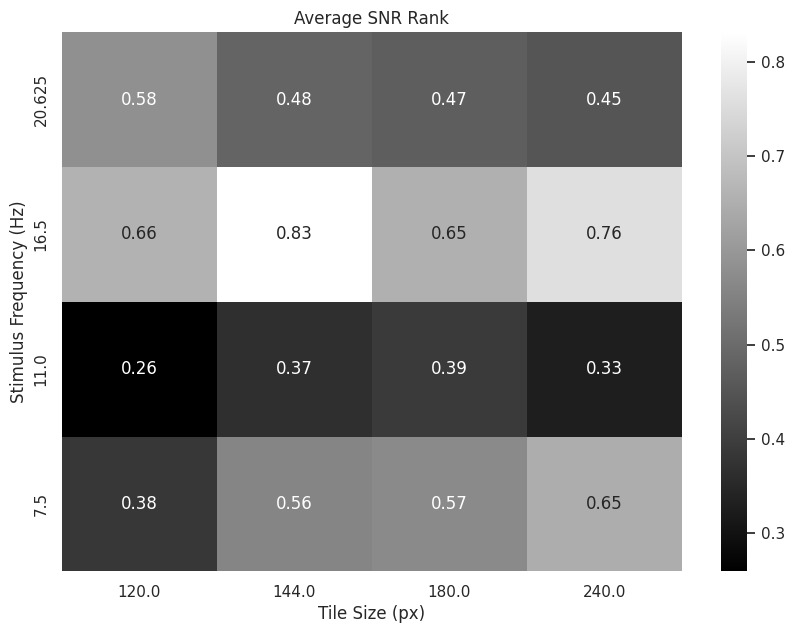

In [23]:
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='grey')
plt.title('Average SNR Rank')
plt.xlabel('Tile Size (px)')
plt.ylabel('Stimulus Frequency (Hz)')
plt.show()